In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [7]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head(40)

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N
5,25000.0,0.1797,634.43,MORTGAGE,90000.0,Source Verified,Mar-2019,low_risk,n,18.49,...,93.1,66.7,0.0,0.0,550717.0,418934.0,18800.0,369051.0,N,N
6,20400.0,0.2000,540.48,RENT,51315.0,Source Verified,Mar-2019,low_risk,n,25.63,...,100.0,0.0,1.0,0.0,40023.0,23469.0,3500.0,27523.0,N,N
7,10000.0,0.1557,349.46,OWN,66000.0,Source Verified,Mar-2019,low_risk,n,9.00,...,100.0,16.7,0.0,0.0,29300.0,22377.0,8400.0,12500.0,N,N
8,14000.0,0.0881,443.96,RENT,45000.0,Not Verified,Mar-2019,low_risk,n,10.24,...,100.0,0.0,0.0,0.0,25100.0,9724.0,12100.0,3000.0,N,N
9,10000.0,0.1474,345.39,RENT,63295.0,Verified,Mar-2019,low_risk,n,39.34,...,97.2,71.4,0.0,0.0,119822.0,102924.0,15300.0,80722.0,N,N


In [8]:
print(pd.unique(df['loan_status']))

['low_risk' 'high_risk']


In [9]:
pd.set_option('display.max_rows', 100)

df.dtypes

loan_amnt                     float64
int_rate                      float64
installment                   float64
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
total_acc                     float64
initial_list_status            object
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt                   float64
total_pymnt_inv               float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
last_pymnt_a

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['loan_status'] = le.fit_transform(df['loan_status'])

In [11]:
# Create training variables by converting the string values into numerical ones using the get_dummies() method.
df_binary_encoded = pd.get_dummies(df, columns=["home_ownership", "verification_status", "issue_d", "pymnt_plan", "initial_list_status", "next_pymnt_d", "application_type", "hardship_flag", "debt_settlement_flag"])
df_binary_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,1,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,1,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,1,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,1,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,1,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,0,1,1,0,1,1


In [12]:
pd.set_option('display.max_rows', 100)

df_binary_encoded.dtypes

loan_amnt                              float64
int_rate                               float64
installment                            float64
annual_inc                             float64
loan_status                              int64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
open_acc                               float64
pub_rec                                float64
revol_bal                              float64
total_acc                              float64
out_prncp                              float64
out_prncp_inv                          float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
total_rec_late_fee                     float64
recoveries                             float64
collection_recovery_fee                float64
last_pymnt_am

# Split the Data into Training and Testing

In [13]:
# Create our features
x_cols = [i for i in df_binary_encoded.columns if i not in ('loan_status')]
X = df_binary_encoded[x_cols]

# Create our target
y = df_binary_encoded['loan_status']

In [14]:
# check the original balance of target risk values
Counter(y)

Counter({1: 68470, 0: 347})

In [15]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [17]:
# Check the balance of our target values
df_binary_encoded['loan_status'].value_counts()

1    68470
0      347
Name: loan_status, dtype: int64

In [18]:
# Original train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [39]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape 

# Instantiate
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model
brfc.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [40]:
# Calculated the balanced accuracy score
y_pred = brfc.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7887512850910909

In [41]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,71,30
Actual low_risk,2146,14958


In [42]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.03      0.70      0.87      0.06      0.78      0.60       101
          1       1.00      0.87      0.70      0.93      0.78      0.63     17104

avg / total       0.99      0.87      0.70      0.93      0.78      0.63     17205



[0.01057991 0.0296696  0.01980243 0.01483256 0.01747063 0.00308285
 0.00621641 0.00738223 0.00201526 0.01492666 0.01020921 0.01488107
 0.01685829 0.05883807 0.05625614 0.07876809 0.05355513 0.00699883
 0.         0.         0.05003318 0.00071503 0.         0.
 0.00419858 0.0128559  0.00975384 0.00748972 0.00486002 0.00656143
 0.01353413 0.01196899 0.01311545 0.00401892 0.00563455 0.01489935
 0.01304461 0.01336476 0.0062406  0.00608322 0.01277358 0.0067145
 0.0133229  0.01326593 0.01461382 0.00027308 0.         0.01392109
 0.01485945 0.00939335 0.01098295 0.00617089 0.01057536 0.01522071
 0.00375719 0.00686666 0.00963247 0.00757054 0.00872448 0.00966205
 0.00833097 0.01032007 0.00727267 0.00862894 0.         0.
 0.00099569 0.00754881 0.01303005 0.00513105 0.00137279 0.
 0.01448769 0.01641297 0.0130453  0.01279909 0.0004956  0.00145897
 0.00282452 0.00291332 0.00220495 0.00150464 0.00193258 0.00564021
 0.02112913 0.01511524 0.         0.00110057 0.00115207 0.005106
 0.00503665 0.0019016 

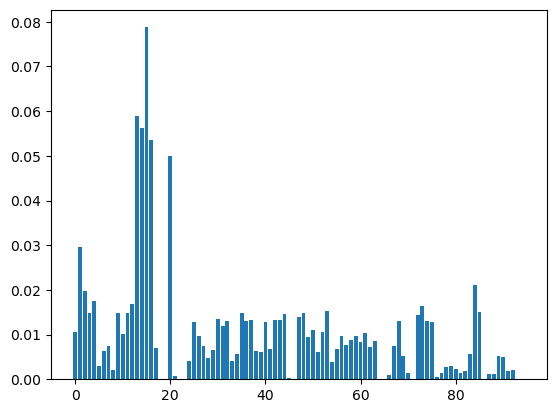

In [43]:
# List the features sorted in descending order by feature importance
from matplotlib import pyplot as plt
features_rank = brfc.feature_importances_

print(features_rank)
plt.bar(x = range(len(features_rank)), height=features_rank)
plt.show()

In [46]:
# List the features sorted in descending order by feature importance

importance_df = pd.DataFrame(sorted(zip(brfc.feature_importances_, X.columns), reverse=True))
importance_df.columns = ['Feature_Importance', 'Feature']
sorted(zip(brfc.feature_importances_, X.columns), reverse=True)

[(0.07876809003486353, 'total_rec_prncp'),
 (0.05883806887524815, 'total_pymnt'),
 (0.05625613759225244, 'total_pymnt_inv'),
 (0.05355513093134745, 'total_rec_int'),
 (0.0500331813446525, 'last_pymnt_amnt'),
 (0.02966959508700077, 'int_rate'),
 (0.021129125328012987, 'issue_d_Jan-2019'),
 (0.01980242888931366, 'installment'),
 (0.01747062730041245, 'dti'),
 (0.016858293184471483, 'out_prncp_inv'),
 (0.01641297102011915, 'total_bal_ex_mort'),
 (0.015220714904737209, 'mths_since_recent_inq'),
 (0.015115240704562424, 'issue_d_Mar-2019'),
 (0.014926655663448373, 'revol_bal'),
 (0.014899352873994727, 'max_bal_bc'),
 (0.014881069023035237, 'out_prncp'),
 (0.014859446582326507, 'mo_sin_old_rev_tl_op'),
 (0.014832564501144122, 'annual_inc'),
 (0.014613819728800227, 'bc_util'),
 (0.014487685026878092, 'tot_hi_cred_lim'),
 (0.013921085423763812, 'mo_sin_old_il_acct'),
 (0.013534131593418711, 'mths_since_rcnt_il'),
 (0.013364759441576994, 'total_rev_hi_lim'),
 (0.01332289882475225, 'avg_cur_bal')

### Easy Ensemble AdaBoost Classifier

In [61]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier

eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_model.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [62]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred_eec = eec_model.predict(X_test)
adaboost_acc = balanced_accuracy_score(y_test, y_pred_eec)
print(f'Accuracy score for AdaBoost is: {adaboost_acc}')

Accuracy score for AdaBoost is: 0.9316600714093861


In [65]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, y_pred_eec)
cm_df = pd.DataFrame(
    matrix, index=["Actual High-Risk", "Actual Low-Risk"], columns=["Predicted High_Risk", "Predicted Low_Risk"])
cm_df

,Predicted High_Risk,Predicted Low_Risk
Actual High-Risk,93,8
Actual Low-Risk,983,16121


In [66]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced 
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.09      0.92      0.94      0.16      0.93      0.87       101
          1       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

